In [27]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import seaborn as sns
from scipy.interpolate import UnivariateSpline
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from scipy.stats import trim_mean
from sklearn.metrics import r2_score

In [35]:
df_comb = []
exps = ["qqp_dropout"]
for exp in exps:
    fname = f"{exp}_max_eval_acc.pkl"
    df_seed = pd.read_pickle(fname)
#     with open(fname, "rb") as fh:
#         df_seed = pickle.load(fh)
    df_comb.append(df_seed)
df = pd.concat(df_comb)


In [36]:
df["sample_prob"] = 1.00
df

,eval/accuracy,lr,subsamp_ratio,dropout,seed,sample_prob
60,0.711798,0.00001,0.25,0.05,1,1.0
24,0.641108,0.00001,0.25,0.25,1,1.0
56,0.665372,0.00001,0.25,0.10,1,1.0
55,0.645338,0.00001,0.25,0.15,1,1.0
14,0.639129,0.00001,0.25,0.20,1,1.0
...,...,...,...,...,...,...
61,0.819787,0.00040,1.00,0.30,1,1.0
61,0.809349,0.00040,1.00,0.35,1,1.0
67,0.801731,0.00040,1.00,0.40,1,1.0
60,0.795177,0.00040,1.00,0.45,1,1.0


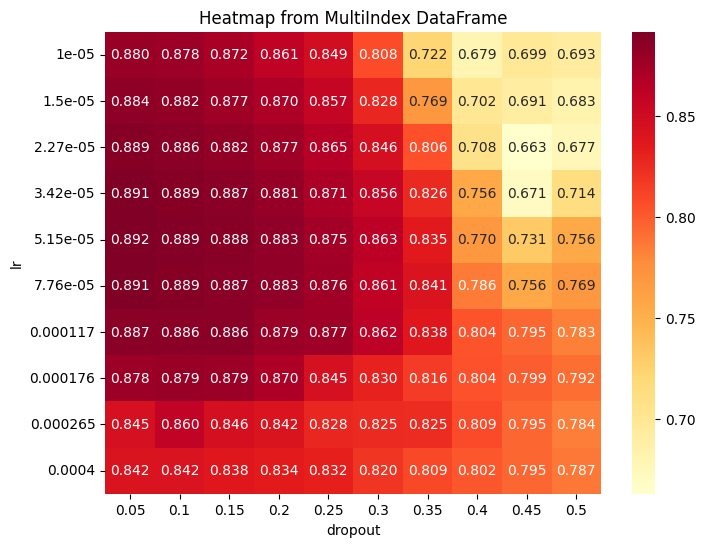

dropout,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50
lr,,,,,,,,,,
0.000010,0.879644,0.877690,0.871506,0.861489,0.848726,0.807544,0.722360,0.679372,0.698862,0.692852
0.000015,0.884393,0.882142,0.877195,0.869973,0.857408,0.827801,0.769256,0.701583,0.691145,0.683107
0.000023,0.888548,0.885803,0.882488,0.877047,0.865075,0.845709,0.806085,0.707717,0.663196,0.677319
0.000034,0.891318,0.888523,0.886718,0.881029,0.870641,0.856245,0.826317,0.756122,0.670641,0.714074
0.000051,0.891862,0.889364,0.887930,0.882983,0.875117,0.862503,0.834801,0.769824,0.731190,0.755503
0.000078,0.891021,0.889043,0.886891,0.883131,0.875884,0.860648,0.841207,0.786372,0.756270,0.768687
0.000117,0.887336,0.885629,0.886099,0.879001,0.877319,0.862231,0.837818,0.803661,0.795078,0.783379
0.000176,0.878457,0.879421,0.878580,0.869701,0.845066,0.830398,0.816003,0.804378,0.799060,0.791640
0.000265,0.845115,0.860203,0.845906,0.841825,0.827974,0.825155,0.824635,0.808756,0.794979,0.783849


In [37]:
df_avg = df.groupby(['subsamp_ratio', 'sample_prob', 'lr', 'dropout']).mean()
df_std = df.groupby(['subsamp_ratio', 'sample_prob', 'lr', 'dropout']).std()
subsamp_ratios = sorted(df_avg.index.get_level_values('subsamp_ratio').unique())[::-1]
sample_probs = sorted(df_avg.index.get_level_values('sample_prob').unique())

idx_tup = (subsamp_ratios[0], sample_probs[0])
df_from_tup = df_avg.loc[idx_tup, :]
lrs = df_from_tup.index.get_level_values('lr').unique()
dropouts = df_from_tup.index.get_level_values('dropout').unique()
df_pivot = df_from_tup.pivot_table(index='lr', columns='dropout', values='eval/accuracy')

plt.figure(figsize=(8, 6))
sns.heatmap(df_pivot, annot=True, cmap='YlOrRd', cbar=True, fmt='.3f')
plt.title('Heatmap from MultiIndex DataFrame')
plt.xlabel('dropout')
plt.ylabel('lr')
plt.show()

df_pivot

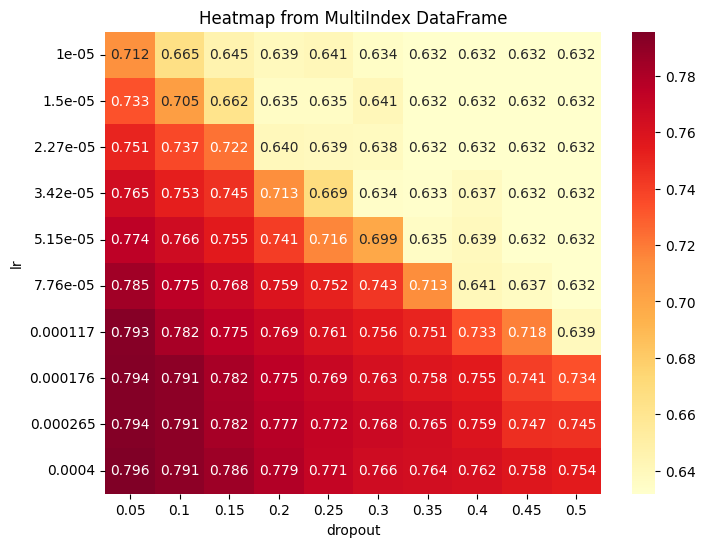

dropout,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50
lr,,,,,,,,,,
0.000010,0.711798,0.665372,0.645338,0.639129,0.641108,0.634405,0.631833,0.631833,0.631833,0.631833
0.000015,0.733144,0.704551,0.662330,0.635197,0.635147,0.641059,0.631833,0.631833,0.631833,0.631833
0.000023,0.750581,0.736705,0.722261,0.639772,0.638610,0.637868,0.631882,0.631833,0.631833,0.631833
0.000034,0.764853,0.753079,0.745189,0.712590,0.668885,0.634207,0.632649,0.637250,0.631833,0.631833
0.000051,0.774103,0.766040,0.755256,0.740984,0.715805,0.698763,0.635221,0.639030,0.631833,0.631833
0.000078,0.784690,0.774969,0.768266,0.759065,0.751546,0.743186,0.713307,0.640787,0.636681,0.631833
0.000117,0.793470,0.781870,0.774895,0.768810,0.760772,0.755850,0.750829,0.733094,0.717759,0.638882
0.000176,0.793866,0.790947,0.782117,0.774845,0.769453,0.762676,0.758447,0.755058,0.740539,0.734084
0.000265,0.793866,0.790552,0.782365,0.776527,0.771531,0.767524,0.764878,0.758793,0.746772,0.745412


In [38]:
idx_tup = (subsamp_ratios[1], sample_probs[0])
df_from_tup = df_avg.loc[idx_tup, :]
lrs = df_from_tup.index.get_level_values('lr').unique()
dropouts = df_from_tup.index.get_level_values('dropout').unique()
df_pivot = df_from_tup.pivot_table(index='lr', columns='dropout', values='eval/accuracy')

plt.figure(figsize=(8, 6))
sns.heatmap(df_pivot, annot=True, cmap='YlOrRd', cbar=True, fmt='.3f')
plt.title('Heatmap from MultiIndex DataFrame')
plt.xlabel('dropout')
plt.ylabel('lr')
plt.show()

df_pivot

In [39]:

# all_lrs = sorted(df_avg.index.get_level_values('lr').unique())


best_lrs = np.zeros((len(subsamp_ratios), len(sample_probs)))
best_dropout = np.zeros((len(subsamp_ratios), len(sample_probs)))

best_lrs_smooth = np.zeros((len(subsamp_ratios), len(sample_probs)))
best_lrs_spline = np.zeros((len(subsamp_ratios), len(sample_probs)))

sigma = 0.1
count = 0
for subsamp_ratio_idx in range(len(subsamp_ratios)):
    for sample_prob_idx in range(len(sample_probs)):
        count += 1
        idx_tup = (subsamp_ratios[subsamp_ratio_idx], sample_probs[sample_prob_idx])
        df_from_tup = df_avg.loc[idx_tup, :]
#         if 15 < count < 20:
#             plt.figure()
#             print(idx_tup)
#             plt.plot(np.log(lrs), df_from_tup["eval/accuracy"])
        lrs = df_from_tup.index.get_level_values('lr').unique()
        lr_max = df_from_tup["eval/accuracy"].idxmax()
        smoothed_vals = gaussian_filter1d(df_from_tup["eval/accuracy"], sigma)
        log_lrs = np.log(lrs)
        spl = UnivariateSpline(log_lrs, df_from_tup["eval/accuracy"])
        xs = np.linspace(np.min(log_lrs), np.max(log_lrs))
        lr_max_spline = np.exp(xs[np.argmax(spl(xs))])
        lr_max_smooth = lrs[np.argmax(smoothed_vals)]
        acc_max = df_from_tup.loc[lr_max, "eval/accuracy"]
        best_lrs[subsamp_ratio_idx, sample_prob_idx] = lr_max
        best_lrs_smooth[subsamp_ratio_idx, sample_prob_idx] = lr_max_smooth
        best_lrs_spline[subsamp_ratio_idx, sample_prob_idx] = lr_max_spline

        


ValueError: x and y should have a same length

In [69]:
lrs_one = np.array(sorted(df_avg.loc[(1.00, 1.00), :].index.get_level_values('lr').unique()))
acc_one = df_avg.loc[(1.00, 1.00), :]["eval/accuracy"].values

[0.877271   0.87947234 0.88138841 0.88302745 0.88438123 0.88569874
 0.88710199 0.88794295 0.88891418 0.8895111  0.89013109 0.89020364
 0.89031412 0.88969082 0.88900156 0.88727512 0.88707726 0.8855124
 0.87983181 0.87435898]


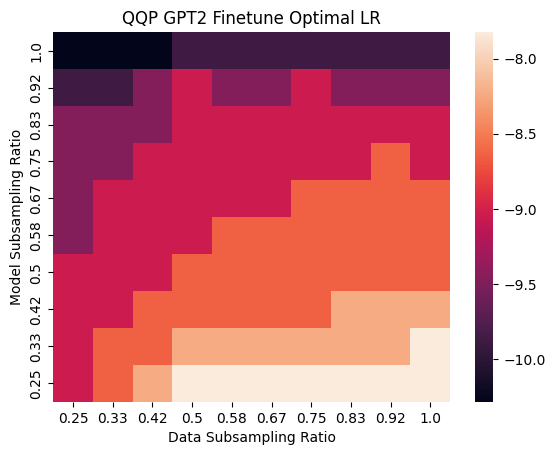

In [41]:
best_lrs_log = gaussian_filter(np.log(best_lrs_smooth), 0)
s = sns.heatmap(best_lrs_log, xticklabels=sample_probs, yticklabels=subsamp_ratios, vmin=np.min(best_lrs_log), vmax=np.max(best_lrs_log))
s.set_xlabel("Data Subsampling Ratio")
s.set_ylabel("Model Subsampling Ratio")
s.set_title("QQP GPT2 Finetune Optimal LR")
fig = s.get_figure()

# fig.savefig("mnli_gpt2_opt_lr.png")
plt.show()


In [42]:
x_grid = subsamp_ratios
y_grid = sample_probs
X, Y = np.meshgrid(x_grid, y_grid)
all_obs = np.vstack((X.ravel(), Y.ravel())).T
vals = best_lrs_log.ravel(order='F')

In [43]:
from scipy.interpolate import RBFInterpolator, NearestNDInterpolator, LinearNDInterpolator
mse = 0
num_trials = 1000
for trial in range(num_trials):
    num_obs = 100
    train_idx = np.sort(np.random.choice(len(all_obs), size=num_obs, replace=False))
    test_idx = np.sort(np.array([i for i in range(len(all_obs)) if i not in train_idx]))
    interp = RBFInterpolator(all_obs[train_idx], vals[train_idx], kernel="thin_plate_spline", smoothing=1)
    # interp = NearestNDInterpolator(all_obs[train_idx], vals[train_idx])
    preds = interp(all_obs)
    mse += np.mean(np.square(preds - vals))
mse = mse / num_trials
print(mse)

0.028539853897907422


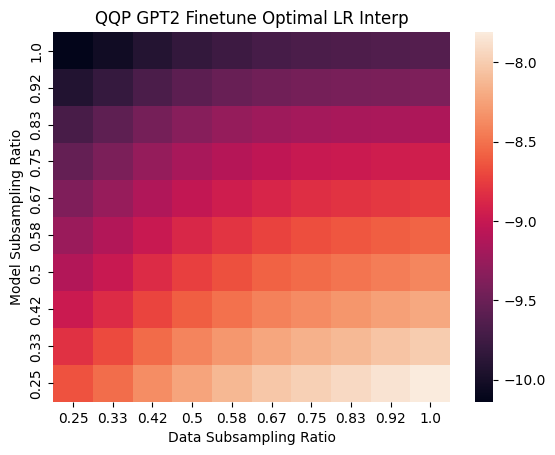

In [44]:
preds_grid = np.reshape(preds, (len(x_grid), len(y_grid)), order='F')
s = sns.heatmap(preds_grid, xticklabels=sample_probs, yticklabels=subsamp_ratios, vmin=np.min(preds_grid), vmax=np.max(preds_grid))
s.set_xlabel("Data Subsampling Ratio")
s.set_ylabel("Model Subsampling Ratio")
s.set_title("QQP GPT2 Finetune Optimal LR Interp")
fig = s.get_figure()
# fig.savefig("mnli_gpt2_opt_lr.png")
plt.show()

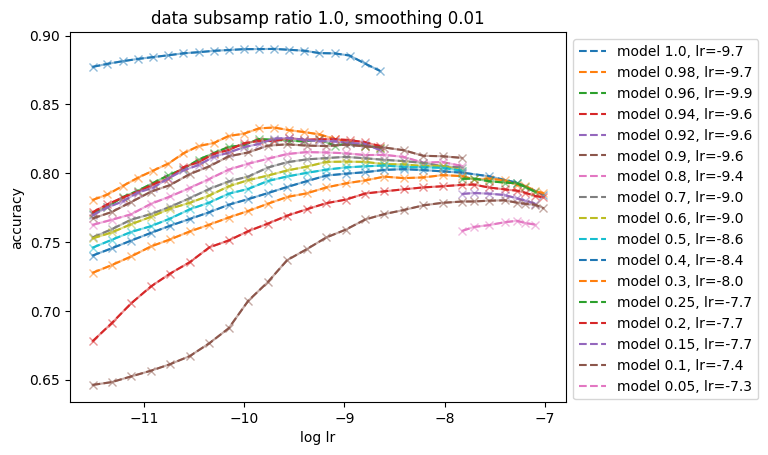

In [19]:
# df_avg
sigma = 0.01
count = 0
sample_prob_idx = 0
for subsamp_ratio_idx in range(len(subsamp_ratios)):
    if True or (subsamp_ratio_idx) == 0 or subsamp_ratio_idx > 4:
        idx_tup = (subsamp_ratios[subsamp_ratio_idx], sample_probs[sample_prob_idx])
        df_from_tup = df_avg.loc[idx_tup, :]
        lrs = df_from_tup.index.get_level_values('lr').unique()
        lr_max = df_from_tup["eval/accuracy"].idxmax()
        log_lrs = np.log(lrs)
        spl = UnivariateSpline(log_lrs, df_from_tup["eval/accuracy"])
        xs = np.linspace(np.min(log_lrs), np.max(log_lrs))
        smoothed_vals = gaussian_filter1d(df_from_tup["eval/accuracy"], sigma)
        lr_max_smooth = log_lrs[np.argmax(smoothed_vals)]
        lr_max_spline = xs[np.argmax(spl(xs))]
        
        plt.plot(np.log(lrs), df_from_tup["eval/accuracy"], alpha=0.5, marker="x")
        line = plt.gca().lines[count]
        line_color = line.get_color()
        plt.plot(np.log(lrs), smoothed_vals, color=line_color, linestyle='--', label=f"model {idx_tup[0]}, lr={np.round(lr_max_smooth, 1)}")
        # plt.plot(xs, spl(xs), color=line_color, linestyle='dashdot')
        # plt.axvline(x=np.log(lr_max_smooth), color=line_color, linestyle=':')
        count += 2
plt.legend(bbox_to_anchor=(1, 1))
plt.title(f"data subsamp ratio {idx_tup[1]}, smoothing {sigma}")
plt.xlabel('log lr')
plt.ylabel('accuracy')
plt.show()

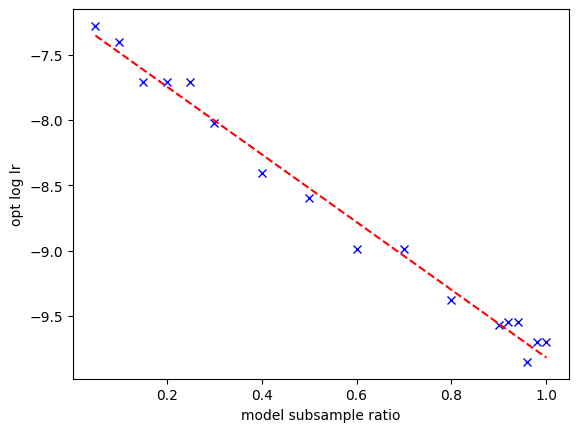

r2 score: 0.9861292423307355
-2.5969363491310395 -7.222749017875262


In [124]:
# best_lrs_smooth_p = np.delete(best_lrs_smooth, np.s_[1:5])
# subsamp_ratios_p = np.delete(subsamp_ratios, np.s_[1:5])

best_lrs_smooth_p = np.array(best_lrs_smooth).flatten()
subsamp_ratios_p = np.array(subsamp_ratios).flatten()

plt.plot(subsamp_ratios_p, np.log(best_lrs_smooth_p), 'bx')
slope, intercept = np.polyfit(subsamp_ratios_p, np.log(best_lrs_smooth_p), deg=1)
x_grid = np.linspace(np.min(subsamp_ratios_p), np.max(subsamp_ratios_p))
pred_vals = slope * subsamp_ratios_p + intercept
lin_vals = slope * x_grid + intercept
plt.plot(x_grid, lin_vals, 'r--')
plt.xlabel("model subsample ratio")
plt.ylabel("opt log lr")
plt.show()

r2 = r2_score(pred_vals, np.log(best_lrs_smooth_p))
print(f"r2 score: {r2}")
print(slope, intercept)

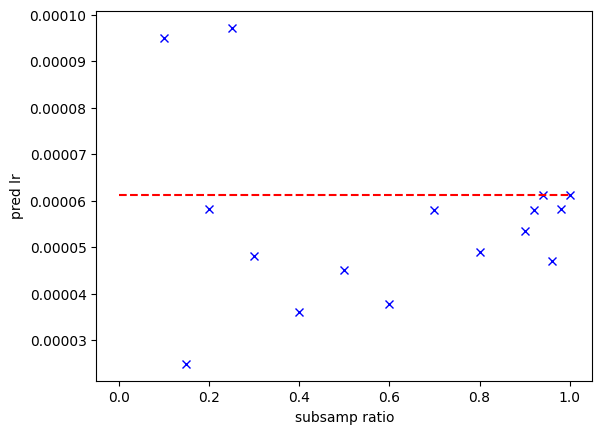

In [125]:
cutoff = 1
C = 0.00075
b = np.log(best_lrs_smooth_p / C) * (1 / subsamp_ratios_p)
one_shot_preds = C * np.exp(b)
plt.plot(subsamp_ratios_p[:-cutoff], one_shot_preds[:-cutoff], 'bx')
x_grid = np.linspace(0, 1)
plt.plot(x_grid, best_lrs_smooth_p[0] * np.ones(len(x_grid)), 'r--')
plt.ylabel('pred lr')
plt.xlabel('subsamp ratio')
plt.show()

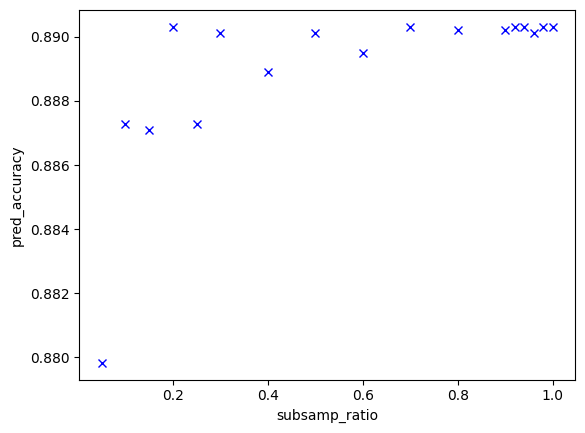

In [126]:
def find_closest_index(x, y):
    z = []
    for elem in y:
        closest_index = np.argmin(np.abs(x - elem))
        z.append(closest_index)
    return z

one_shot_preds_perf = acc_one[find_closest_index(lrs_one, one_shot_preds)]
plt.plot(subsamp_ratios_p, one_shot_preds_perf, 'bx')
plt.ylabel('pred_accuracy')
plt.xlabel('subsamp_ratio')
plt.show()

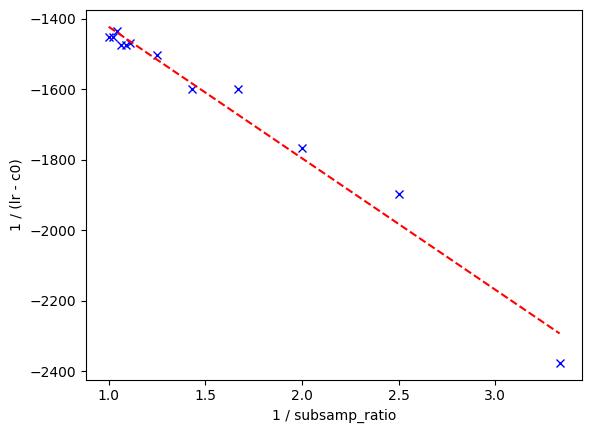

r2 score: 0.9721822557977842
[-372.60580486] [-1050.17735873]


In [119]:
cutoff = 5
best_lrs_smooth_p = np.array(best_lrs_smooth[:-cutoff])
subsamp_ratios_p = np.array(subsamp_ratios[:-cutoff])
c0 = 0.00075
y_lrs = best_lrs_smooth_p - c0
plt.plot(1 / subsamp_ratios_p, 1 / y_lrs, 'bx')

slope_inv, intercept_inv = np.polyfit(1 / subsamp_ratios_p, 1 / y_lrs, deg=1)
x_grid = np.linspace(np.min(1 / subsamp_ratios_p), np.max(1 / subsamp_ratios_p))
pred_vals = slope_inv * (1 / subsamp_ratios_p) + intercept_inv
lin_vals = slope_inv * x_grid + intercept_inv
plt.plot(x_grid, lin_vals, 'r--')
plt.ylabel("1 / (lr - c0)")
plt.xlabel("1 / subsamp_ratio")
plt.show()

r2 = r2_score(pred_vals, 1 / y_lrs)
print(f"r2 score: {r2}")
print(slope_inv, intercept_inv)


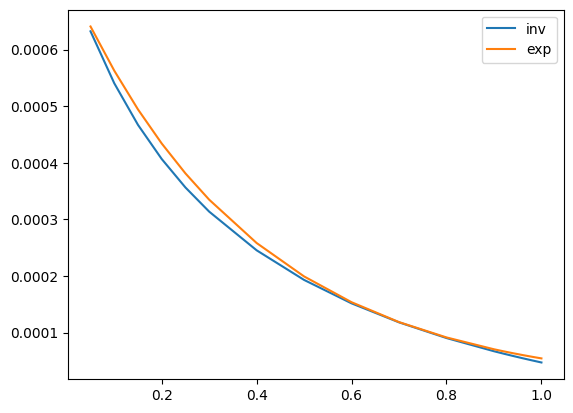

In [118]:
plt.plot(subsamp_ratios_p, c0 + 1 / (slope_inv * (1 / subsamp_ratios_p) + intercept_inv), label="inv")
plt.plot(subsamp_ratios_p, np.exp(intercept) * np.exp(slope * subsamp_ratios_p), label="exp")
plt.legend()
plt.show()

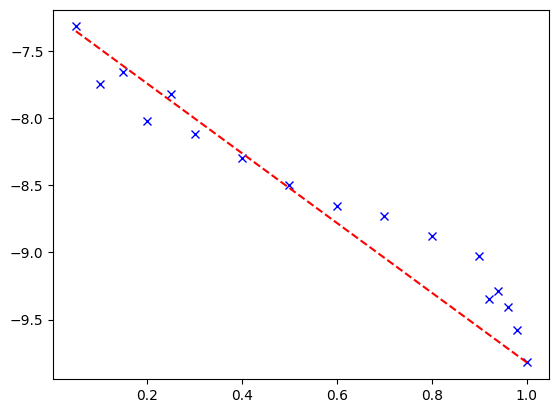

0.9176925069393442


In [108]:
plt.plot(subsamp_ratios, np.log(best_lrs_spline), 'bx')
slope, intercept = np.polyfit(subsamp_ratios, np.log(best_lrs_smooth), deg=1)
x_grid = np.linspace(np.min(subsamp_ratios), np.max(subsamp_ratios))
pred_vals = slope * subsamp_ratios + intercept
lin_vals = slope * x_grid + intercept
plt.plot(x_grid, lin_vals, 'r--')
plt.show()
print(r2_score(pred_vals, np.log(best_lrs_spline)))

In [10]:
best_lrs_smooth

array([[6.12e-05],
       [6.12e-05],
       [5.26e-05],
       [7.12e-05],
       [7.12e-05],
       [6.97e-05],
       [8.46e-05],
       [1.25e-04],
       [1.25e-04],
       [1.84e-04],
       [2.23e-04],
       [3.29e-04],
       [4.50e-04],
       [4.50e-04],
       [4.50e-04],
       [6.10e-04],
       [6.90e-04]])

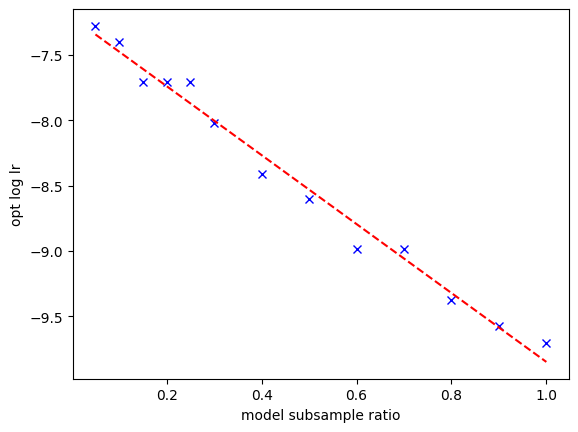

r2 score: 0.9833919051896578
-2.637618288858178 -7.212218507957046


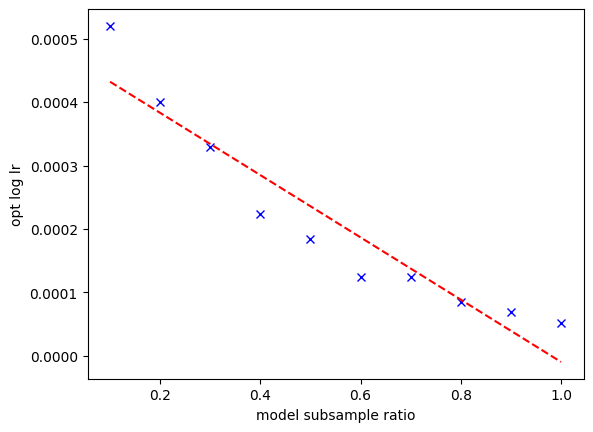

r2 score: 0.8825527498114174


In [95]:
best_lrs_smooth_p = np.delete(best_lrs_smooth, np.s_[1:5])
subsamp_ratios_p = np.delete(subsamp_ratios, np.s_[1:5])

plt.plot(subsamp_ratios_p, best_lrs_smooth_p, 'bx')
slope, intercept = np.polyfit(subsamp_ratios_p, best_lrs_smooth_p, deg=1)
x_grid = np.linspace(np.min(subsamp_ratios_p), np.max(subsamp_ratios_p))
pred_vals = slope * subsamp_ratios_p + intercept
lin_vals = slope * x_grid + intercept

plt.plot(x_grid, lin_vals, 'r--')

plt.xlabel("model subsample ratio")
plt.ylabel("opt log lr")
plt.show()

r2 = r2_score(pred_vals, best_lrs_smooth_p)
print(f"r2 score: {r2}")

In [71]:
slope

-2.5311925682074503

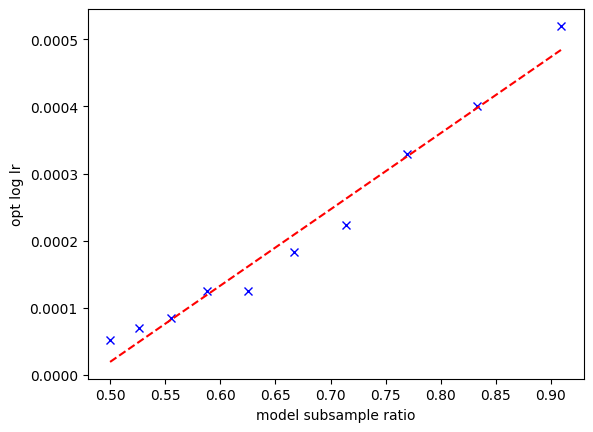

r2 score: 0.9703906016826042


In [63]:
best_lrs_smooth_p = np.delete(best_lrs_smooth, np.s_[1:5])
subsamp_ratios_p = np.delete(subsamp_ratios, np.s_[1:5])
subsamp_ratios_p = 1 / (1 + subsamp_ratios_p)

plt.plot(subsamp_ratios_p, best_lrs_smooth_p, 'bx')
slope, intercept = np.polyfit(subsamp_ratios_p, best_lrs_smooth_p, deg=1)
x_grid = np.linspace(np.min(subsamp_ratios_p), np.max(subsamp_ratios_p))
pred_vals = slope * subsamp_ratios_p + intercept
lin_vals = slope * x_grid + intercept
plt.plot(x_grid, lin_vals, 'r--')
plt.xlabel("model subsample ratio")
plt.ylabel("opt log lr")
plt.show()

r2 = r2_score(pred_vals, best_lrs_smooth_p)
print(f"r2 score: {r2}")

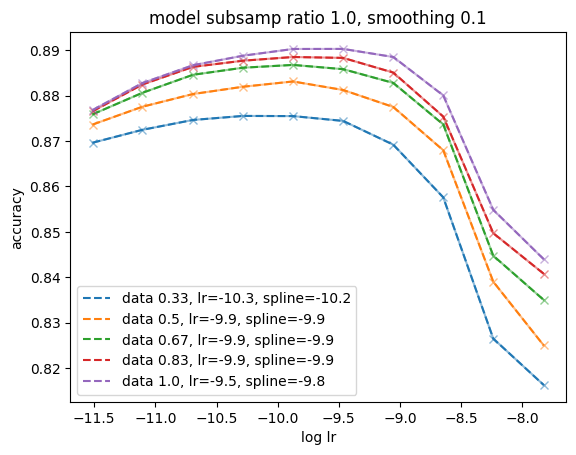

In [30]:
# df_avg
count = 0
subsamp_ratio_idx = 0
for sample_prob_idx in range(len(sample_probs)):
    if (sample_prob_idx + 1) % 2 == 0:
        idx_tup = (subsamp_ratios[subsamp_ratio_idx], sample_probs[sample_prob_idx])
        df_from_tup = df_avg.loc[idx_tup, :]
        lr_max = df_from_tup["eval/accuracy"].idxmax()
        log_lrs = np.log(lrs)
        spl = UnivariateSpline(log_lrs, df_from_tup["eval/accuracy"])
        xs = np.linspace(np.min(log_lrs), np.max(log_lrs))
        sigma = 0.1
        smoothed_vals = gaussian_filter1d(df_from_tup["eval/accuracy"], sigma)
        lr_max_smooth = log_lrs[np.argmax(smoothed_vals)]
        lr_max_spline = xs[np.argmax(spl(xs))]
        
        plt.plot(np.log(lrs), df_from_tup["eval/accuracy"], alpha=0.5, marker="x")
        line = plt.gca().lines[count]
        line_color = line.get_color()
        plt.plot(np.log(lrs), smoothed_vals, color=line_color, linestyle='--', label=f"data {idx_tup[1]}, lr={np.round(lr_max_smooth, 1)}, spline={np.round(lr_max_spline, 1)}")
        # plt.plot(xs, spl(xs), color=line_color, linestyle='dashdot')
        # plt.axvline(x=np.log(lr_max_smooth), color=line_color, linestyle=':')
        count += 2
plt.legend()
plt.title(f"model subsamp ratio {idx_tup[0]}, smoothing {sigma}")
plt.xlabel('log lr')
plt.ylabel('accuracy')
plt.show()

In [31]:
np.log(lrs)

Index([-11.512925464970229, -11.107460356862065, -10.693145633476917,
       -10.283284913895715,  -9.873928750294583,  -9.463943130775101,
        -9.053336623166517,  -8.645026562926123,  -8.235780731978052,
        -7.824046010856292],
      dtype='float64', name='lr')

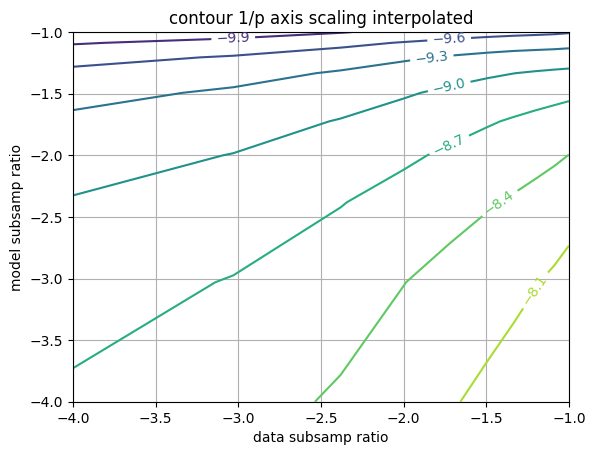

In [32]:
subsamp_ratios_rescale = np.array(subsamp_ratios)
subsamp_ratios_rescale = -1 / subsamp_ratios_rescale

sample_probs_rescale = np.array(sample_probs)
sample_probs_rescale = -1 / sample_probs_rescale
xv, yv = np.meshgrid(sample_probs_rescale, subsamp_ratios_rescale)
CS = plt.contour(xv, yv, preds_grid)
plt.clabel(CS, inline=True, fontsize=10)
# plt.contourf(xv, yv, best_lrs_log)
# plt.scatter(xv, yv, c=best_lrs_log.flatten())
plt.xlabel('data subsamp ratio')
plt.ylabel('model subsamp ratio')
plt.title('contour 1/p axis scaling interpolated')
plt.grid()
plt.show()

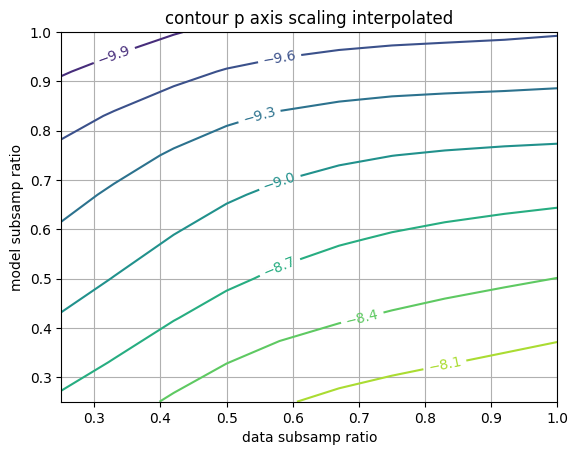

In [33]:
subsamp_ratios_rescale = np.array(subsamp_ratios)
# subsamp_ratios_rescale = -1 / subsamp_ratios_rescale

sample_probs_rescale = np.array(sample_probs)
# sample_probs_rescale = -1 / sample_probs_rescale
xv, yv = np.meshgrid(sample_probs_rescale, subsamp_ratios_rescale)
CS = plt.contour(xv, yv, preds_grid)
plt.clabel(CS, inline=True, fontsize=10)
# plt.contourf(xv, yv, best_lrs_log)
# plt.scatter(xv, yv, c=best_lrs_log.flatten())
plt.xlabel('data subsamp ratio')
plt.ylabel('model subsamp ratio')
plt.title('contour p axis scaling interpolated')
plt.grid()
plt.show()

[ 0.86216052 -2.10655947 -8.15345841]
(100,)


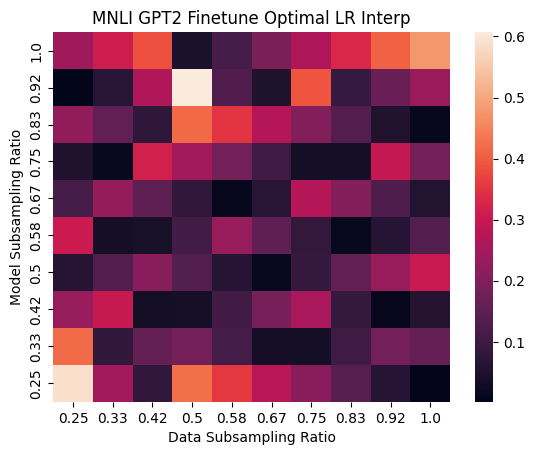

In [34]:
X = np.hstack((all_obs, np.ones((100, 1))))
X[:, [0, 1]] = X[:, [1, 0]]
beta = np.dot(np.linalg.pinv(X), preds)
print(beta)
linear_preds = np.dot(X, beta)
print(linear_preds.shape)
linear_preds_grid = np.reshape(linear_preds, (len(x_grid), len(y_grid)), order='F')
s = sns.heatmap(np.abs(linear_preds_grid - best_lrs_log), xticklabels=sample_probs, yticklabels=subsamp_ratios)
s.set_xlabel("Data Subsampling Ratio")
s.set_ylabel("Model Subsampling Ratio")
s.set_title("MNLI GPT2 Finetune Optimal LR Interp")
fig = s.get_figure()
# fig.savefig("mnli_gpt2_opt_lr.png")
plt.show()

In [45]:
X = np.hstack((all_obs, np.ones((100, 1))))
X[:, [0, 1]] = X[:, [1, 0]]
beta = np.dot(np.linalg.pinv(X), preds)
print(beta)
print(np.dot(beta, np.array([1.0, 1.0, 1])))
print(np.dot(np.linalg.pinv(X), preds - vals))
print(-beta[0] / beta[1], -(9.397857 + beta[2]) / beta[1])
resid = np.dot(X, beta) - vals
rmse = np.sqrt(np.mean(resid * resid))
nrmse = rmse / (np.max(vals) - np.min(vals))
print(nrmse)

[ 0.86216052 -2.10655947 -8.15345841]
-9.397857360711523
[-2.27318164e-14  2.30163111e-14 -2.56045185e-15]
0.40927423785610306 0.5907255909113591
0.08754005562221182


[0.5401493  0.77598806]
[0.52547213 0.66171117]
[0.74331417 0.44218803]
[0.83858313 0.2284744 ]
[0.78222045 0.08024163]
[0.5703218  0.03306086]
[0.3426963  0.04455995]


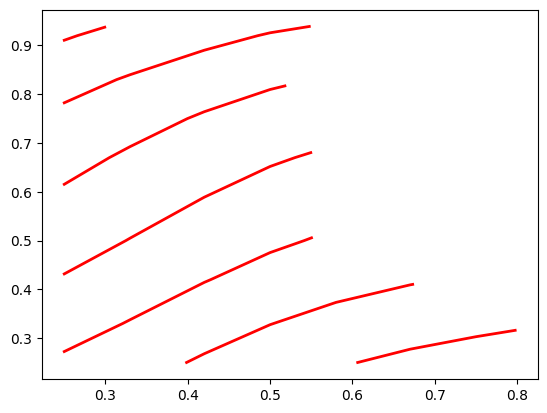

In [36]:
# Extract contour lines
contour_lines = CS.collections

# Access and manipulate contour lines
for contour_line in contour_lines:
    if len(contour_line.get_paths()) > 0:
        # Extract x and y coordinates of contour line
        contour_line_x = contour_line.get_paths()[0].vertices[:, 0]
        contour_line_y = contour_line.get_paths()[0].vertices[:, 1]

        regression_coefficients = np.polyfit(contour_line_x, contour_line_y, deg=1)
        print(regression_coefficients)
        regression_line_y = np.polyval(regression_coefficients, np.linspace(-4, -1))

        # Plot the contour line and the regression line
        plt.plot(contour_line_x, contour_line_y, 'r', linewidth=2)
        # plt.plot(np.linspace(-4, -1), regression_line_y, 'b', linewidth=2)

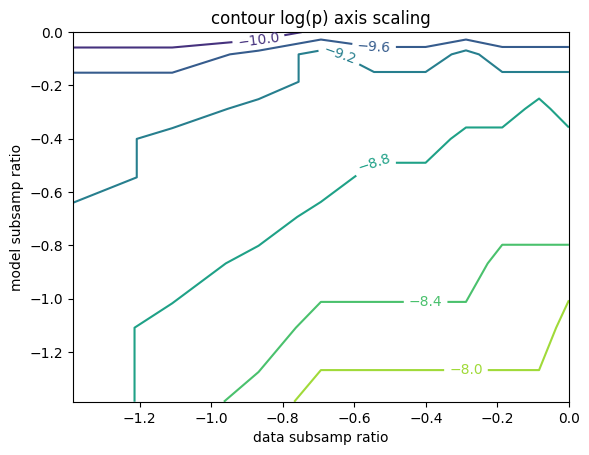

In [37]:
subsamp_ratios_rescale = np.array(subsamp_ratios)
subsamp_ratios_rescale = np.log(subsamp_ratios_rescale)
sample_probs_rescale = np.array(sample_probs)
sample_probs_rescale = np.log(sample_probs_rescale)
xv, yv = np.meshgrid(sample_probs_rescale, subsamp_ratios_rescale)
CS = plt.contour(xv, yv, best_lrs_log)
plt.clabel(CS, inline=True, fontsize=10)
# plt.contourf(xv, yv, best_lrs_log)
# plt.scatter(xv, yv, c=best_lrs_log.flatten())
plt.xlabel('data subsamp ratio')
plt.ylabel('model subsamp ratio')
plt.title('contour log(p) axis scaling')
plt.show()

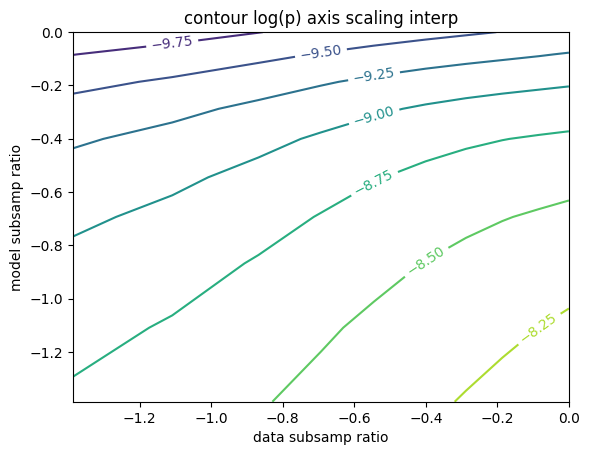

In [139]:
subsamp_ratios_rescale = np.array(subsamp_ratios)
subsamp_ratios_rescale = np.log(subsamp_ratios_rescale)
sample_probs_rescale = np.array(sample_probs)
sample_probs_rescale = np.log(sample_probs_rescale)
xv, yv = np.meshgrid(sample_probs_rescale, subsamp_ratios_rescale)
CS = plt.contour(xv, yv, preds_grid)
plt.clabel(CS, inline=True, fontsize=10)
# plt.contourf(xv, yv, best_lrs_log)
# plt.scatter(xv, yv, c=best_lrs_log.flatten())
plt.xlabel('data subsamp ratio')
plt.ylabel('model subsamp ratio')
plt.title('contour log(p) axis scaling interp')
plt.show()

In [120]:
best_lrs

array([[3.42e-05, 3.42e-05, 3.42e-05, 5.15e-05, 5.15e-05, 5.15e-05,
        5.15e-05, 5.15e-05, 5.15e-05, 7.76e-05],
       [7.76e-05, 5.15e-05, 5.15e-05, 7.76e-05, 7.76e-05, 5.15e-05,
        1.17e-04, 7.76e-05, 7.76e-05, 7.76e-05],
       [7.76e-05, 1.17e-04, 7.76e-05, 1.17e-04, 7.76e-05, 1.17e-04,
        1.17e-04, 1.17e-04, 1.17e-04, 1.17e-04],
       [1.17e-04, 7.76e-05, 7.76e-05, 1.17e-04, 7.76e-05, 1.17e-04,
        1.17e-04, 1.17e-04, 1.76e-04, 1.17e-04],
       [7.76e-05, 1.17e-04, 7.76e-05, 1.17e-04, 1.17e-04, 1.17e-04,
        1.17e-04, 1.76e-04, 1.17e-04, 1.17e-04],
       [1.17e-04, 7.76e-05, 1.17e-04, 1.17e-04, 1.17e-04, 1.76e-04,
        1.17e-04, 1.17e-04, 1.76e-04, 1.76e-04],
       [1.17e-04, 1.17e-04, 1.17e-04, 1.76e-04, 1.76e-04, 1.76e-04,
        2.65e-04, 1.76e-04, 1.76e-04, 1.17e-04],
       [1.17e-04, 1.17e-04, 1.76e-04, 1.76e-04, 1.76e-04, 1.76e-04,
        1.76e-04, 2.65e-04, 2.65e-04, 2.65e-04],
       [7.76e-05, 1.17e-04, 2.65e-04, 2.65e-04, 2.65e-04, 1.76e-

In [121]:
np.log(lrs)

Index([-11.512925464970229, -11.107460356862065, -10.693145633476917,
       -10.283284913895715,  -9.873928750294583,  -9.463943130775101,
        -9.053336623166517,  -8.645026562926123,  -8.235780731978052,
        -7.824046010856292],
      dtype='float64', name='lr')